# IMPORT LIBRARY

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# READ DATA AND DATA MANIPULATION

In [2]:
df_real=pd.read_csv("./healthcare-dataset-stroke-data.csv")

In [3]:
df_copy=df_real.copy()

In [4]:
df_copy.shape

(5110, 12)

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df_copy.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df_copy.drop("id",axis=1,inplace=True)

In [8]:
df_copy.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [9]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [10]:
df_copy.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
df_copy.bmi.fillna(df_copy.bmi.mean(),inplace=True)

In [12]:
df_copy.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# DATA VISUALIZATION VIA SEABORN

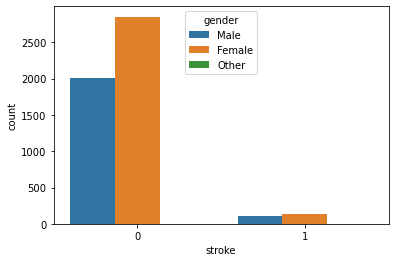

In [13]:
sns.countplot(x="stroke",hue="gender",data=df_copy);

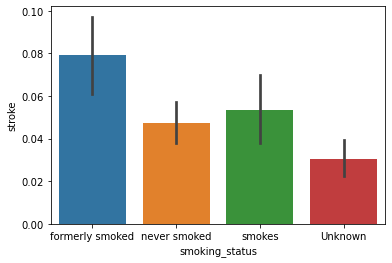

In [14]:
sns.barplot(x="smoking_status",y="stroke",data=df_copy);

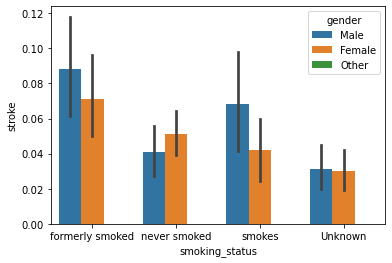

In [15]:
sns.barplot(x="smoking_status",y="stroke",hue="gender",data=df_copy);

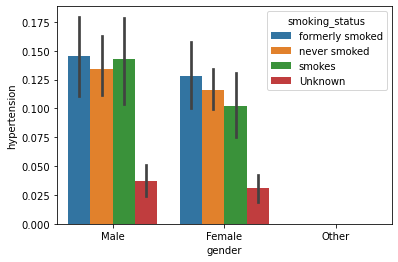

In [16]:
sns.barplot(x="gender",y="hypertension",hue="smoking_status",data=df_copy);

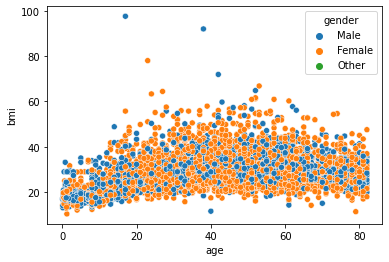

In [17]:
sns.scatterplot(y="bmi",x="age",hue="gender",data=df_copy);

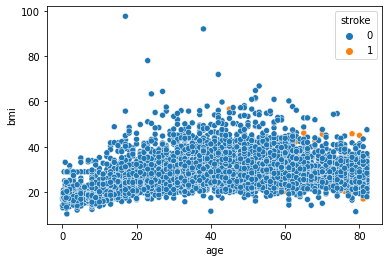

In [18]:
sns.scatterplot(y="bmi",x="age",hue="stroke",data=df_copy);

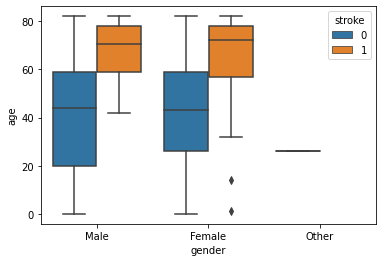

In [19]:
sns.boxplot(x="gender",y="age",hue="stroke",data=df_copy);

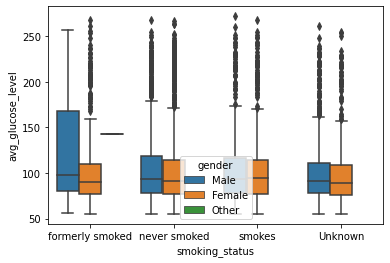

In [20]:
sns.boxplot(x="smoking_status",y="avg_glucose_level",hue="gender",data=df_copy);

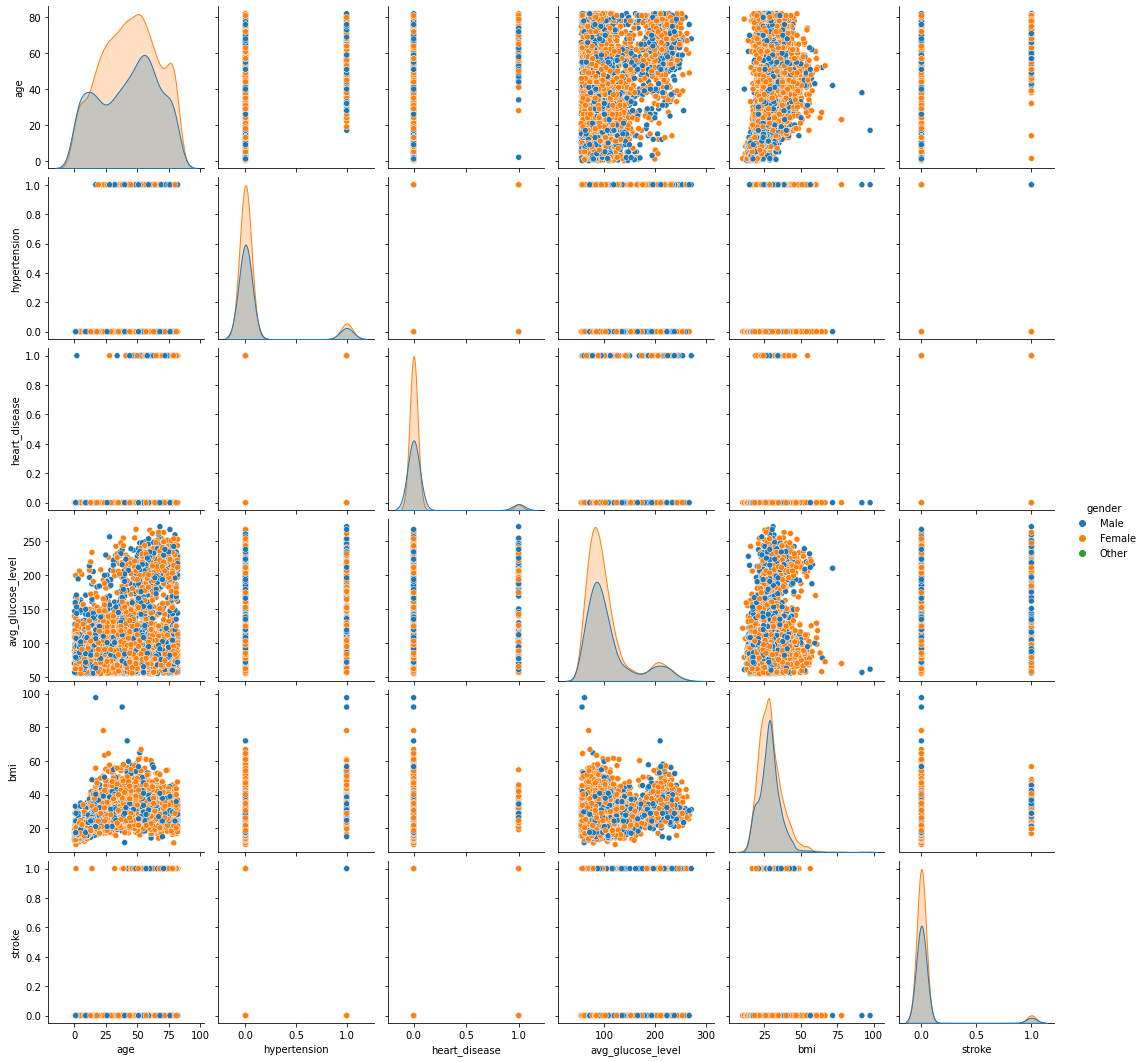

In [21]:
sns.pairplot(df_copy,hue="gender");

# Data Preprocessing

In [22]:
lbe=LabelEncoder()

In [23]:
df_copy.gender=lbe.fit_transform(df_copy.gender)
df_copy.ever_married=lbe.fit_transform(df_copy.ever_married)

In [25]:
df_copy=pd.get_dummies(df_copy,columns=["work_type"])
df_copy=pd.get_dummies(df_copy,columns=["Residence_type"])
df_copy=pd.get_dummies(df_copy,columns=["smoking_status"])

In [26]:
X=df_copy.drop("stroke",axis=1)
y=df_copy.stroke

# RESAMPLİNG 

In [27]:
!pip install imblearn

In [28]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

# Create Basical Model

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.2,random_state=42)

In [30]:
scl=StandardScaler()

In [31]:
X_train=scl.fit_transform(X_train)
X_test=scl.fit_transform(X_test)

In [32]:
lgbm_model=LGBMRegressor().fit(X_train,y_train)

In [33]:
y_pred=lgbm_model.predict(X_test)

In [34]:
confusion_matrix(y_test,y_pred.round())

array([[960,  15],
       [ 55, 915]], dtype=int64)

In [35]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       975
           1       0.98      0.94      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



In [36]:
params={
    "num_leaves":[10,20,31,40,50,60,70,80,80,100],
    "learning_rate":[0.01,0.03,0.05,0.07,0.09,0.1],
    "n_estimators":[5,10,15,20,25,30,35,40,45,90,100]
}

In [37]:
lgbm_model=LGBMRegressor()

In [38]:
lgbm_=GridSearchCV(estimator=lgbm_model,param_grid=params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train)

Fitting 10 folds for each of 660 candidates, totalling 6600 fits


In [39]:
lgbm_.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 100}

# Tuning Model

In [40]:
lgbm_tuning=LGBMRegressor(learning_rate=0.1,n_estimators=100,num_leaves=100).fit(X_train,y_train)

In [41]:
y_pred=lgbm_tuning.predict(X_test)

In [42]:
confusion_matrix(y_test,y_pred.round())

array([[953,  22],
       [ 39, 931]], dtype=int64)

In [43]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       975
           1       0.98      0.96      0.97       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



In [44]:
accuracy_score(y_test,y_pred.round())

0.9686375321336761